In [ ]:
#| default_exp opt

In [ ]:
#| export
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from fastcore.all import *
from pathlib import Path
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from fastprogress import progress_bar

In [ ]:
from torchvision import models, transforms as VT, datasets
from torchview import draw_graph
import matplotlib.pyplot as plt

In [ ]:
model = models.inception_v3(weights='IMAGENET1K_V1')
tfms = VT.Compose([VT.Resize(299), VT.ToTensor()])
ds = datasets.Imagenette(root='../data', transform=tfms)

In [ ]:
dl = DataLoader(ds, batch_size=2)
xb, yb = next(iter(dl))

<matplotlib.image.AxesImage>

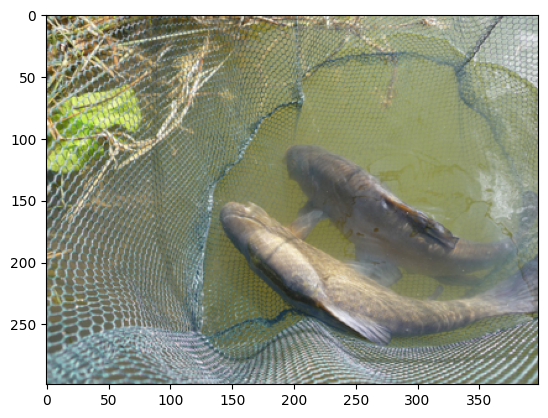

In [ ]:
plt.imshow(xb[0].permute(1, 2, 0))

In [ ]:
draw_graph(model, input_data=xb, save_graph=True, graph_name='inception_v3')

<torchview.computation_graph.ComputationGraph>

In [ ]:
#| export
class Hook:
    def __init__(self, module, hook, when='forward'): 
        attr = f'register_full_{when}_hook' if 'back' in when else f'register_{when}_hook'
        self.hook = getattr(module, attr)(hook)
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

class Hooks(list):
    def __init__(self, *ms, fn, when='forward'): super().__init__([Hook(m, fn, when) for m in ms])
    def __delitem__(self, i): 
        self[i].remove()
        del super()[i]
    def remove(self): 
        for h in self: h.remove()
    def __del__(self): self.remove()
    def __enter__(self): return self
    def __exit__(self, *_): self.remove()

In [ ]:
def get_neurons(module, input, output):
    print(output.shape)


with Hooks(*model.children(), fn=get_neurons):
    model(xb.cuda())

torch.Size([2, 32, 149, 198])
torch.Size([2, 32, 147, 196])
torch.Size([2, 64, 147, 196])
torch.Size([2, 64, 73, 97])
torch.Size([2, 80, 73, 97])
torch.Size([2, 192, 71, 95])
torch.Size([2, 192, 35, 47])
torch.Size([2, 256, 35, 47])
torch.Size([2, 288, 35, 47])
torch.Size([2, 288, 35, 47])
torch.Size([2, 768, 17, 23])
torch.Size([2, 768, 17, 23])
torch.Size([2, 768, 17, 23])
torch.Size([2, 768, 17, 23])
torch.Size([2, 768, 17, 23])
torch.Size([2, 1000])
torch.Size([2, 1280, 8, 11])
torch.Size([2, 2048, 8, 11])
torch.Size([2, 2048, 8, 11])
torch.Size([2, 2048, 1, 1])
torch.Size([2, 2048, 1, 1])
torch.Size([2, 1000])


In [ ]:
#| export
class CancelFitException(Exception): pass

In [ ]:
import torchvision.transforms as T

standard_transforms = T.Compose([
    T.Pad(12, fill=0.5, padding_mode="constant"),
    T.RandomAffine(degrees=0, translate=(1/32, 1/32)),
    T.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.1)),
    T.RandomApply([T.RandomRotation(degrees=(-10, 10))], p=0.7),
    T.RandomAffine(degrees=0, translate=(1 / 64, 1 / 64))])


In [ ]:
import numpy as np
# From https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_image(shape, sd=None, decay_power=1, device='cuda'):
    batch, channels, h, w = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (batch, channels) + freqs.shape + (2,) # 2 for imaginary and real components
    sd = sd or 0.01

    spectrum_real_imag_t = (torch.randn(*init_val_size) * sd).to(device).requires_grad_()

    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale = torch.tensor(scale).float()[None, None, ..., None].to(device)

    def inner():
        scaled_spectrum_t = scale * spectrum_real_imag_t
        if type(scaled_spectrum_t) is not torch.complex64:
            scaled_spectrum_t = torch.view_as_complex(scaled_spectrum_t)
        image = torch.fft.irfftn(scaled_spectrum_t, s=(h, w), norm='ortho')
        image = image[:batch, :channels, :h, :w]
        magic = 4.0 # Magic constant from Lucid library; increasing this seems to reduce saturation
        image = image / magic
        return image
    return spectrum_real_imag_t, inner


In [ ]:
# color correlation
cc_svd_sqrt = torch.tensor([[0.26, 0.09, 0.02],
                            [0.27, 0.00, -0.05],
                            [0.27, -0.09, 0.03]])

cc_norm = cc_svd_sqrt / cc_svd_sqrt.norm(dim=0).max()


def linear_decorrelate_color(img):
    t_permute = img.permute(0, 2, 3, 1) @ cc_norm.T.to(img.device)
    return t_permute.permute(0, 3, 1, 2)


def to_valid_rgb(img, decorr=True):
    if decorr: img = linear_decorrelate_color(img)
    return torch.sigmoid(img)

def to_display(img):
    if img.shape[0] == 1 and len(img.shape) == 4: img = img[0]
    return img.detach().permute(1, 2, 0).cpu().numpy()

In [ ]:
def optimize(model, module, input_shape=(1,3,256,256), n_steps=100, idx=0, fft=True):
    model = model.eval()
    loss = None
    def stop_training(module, input, output):
        nonlocal loss
        loss = output
        raise CancelFitException('Stop training', module)
        
    
    dev = next(model.parameters()).device
    x = (torch.randn(*input_shape, device=dev)*0.01).requires_grad_()
    inner = lambda: x
    if fft: x, inner = fft_image(input_shape, device=dev)
    xs = []
    opt = optim.Adam([x], lr=5e-2)
    pb = progress_bar(range(n_steps))
    for _ in pb:
        opt.zero_grad()
        with Hooks(module, fn=stop_training):
            try: 
                model(standard_transforms(to_valid_rgb(inner())))
            except CancelFitException as e: pass
            l = -loss[:,idx].mean()
            l.backward()
            opt.step()
            pb.comment = f'loss: {l.item():.3}'
        xs.append(x.detach().cpu())
    return inner()

In [ ]:
res = optimize(model,model.Mixed_5c.branch5x5_2.conv, n_steps=700, idx=2)

<matplotlib.image.AxesImage>

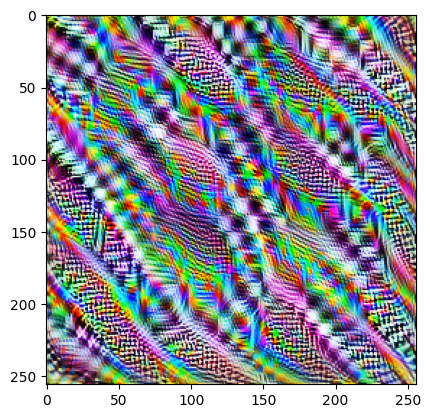

In [ ]:
plt.imshow(to_display(to_valid_rgb(res)))